In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import math as m
import random as rnd
from pathlib import Path
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline


In [2]:
from utils.calibration import clalibrate_camera, getPerspectiveTransformMatrix
from utils.tresholding import get_tresholded_img
from utils.lane_detection import LaneDetector, hist

In [3]:
calibration_images = [cv2.imread('camera_cal/'+img) for img in os.listdir("camera_cal/")]
mtx, dist, rvecs, tvecs, _, _ = clalibrate_camera(calibration_images)


In [4]:
M,Minv = getPerspectiveTransformMatrix()

In [5]:
def cut_edges_(img,length = 200):
    img[:,0:length] = 0
    img[:,img.shape[1] - length:img.shape[1]] = 0

In [6]:
test_img = cv2.imread('challenge/frame0443.jpeg')
# test_img = cv2.imread('project/frame0703.jpeg')
# test_img = cv2.imread('project/frame0596.jpeg')


# test_img = cv2.imread('test_images/straight_lines2.jpg')
test_img = cv2.undistort(test_img, mtx, dist, None)

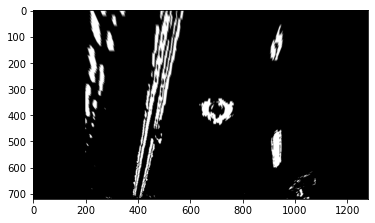

In [7]:
tresholded_img = get_tresholded_img(test_img)
tresholded_img = cv2.warpPerspective(tresholded_img,M,None)
cut_edges_(tresholded_img)
plt.imshow(tresholded_img, cmap='gray')

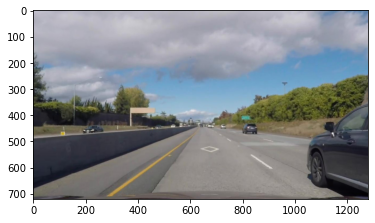

In [8]:
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

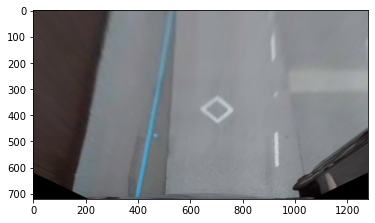

In [9]:
plt.imshow(cv2.warpPerspective(test_img,M,None))

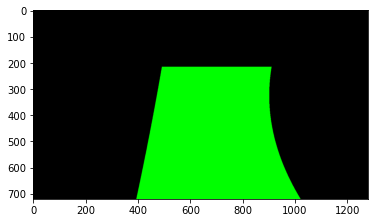

In [10]:
img, curv = LaneDetector().get_lanes(tresholded_img)
plt.imshow(img)

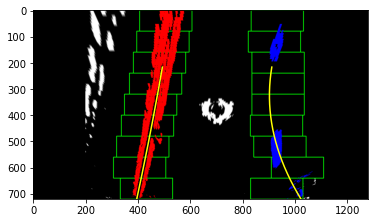

In [55]:
img, curv = LaneDetector().get_lanes(tresholded_img, True)
plt.imshow(img)

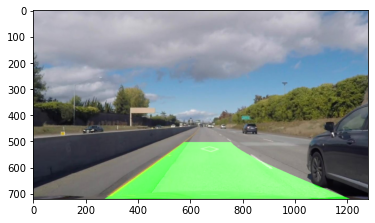

In [11]:
img,_ = LaneDetector().get_lanes(tresholded_img)
result_mask =  cv2.warpPerspective(img,Minv,None)
result = np.copy(test_img)
result[result_mask != 0] = result_mask[result_mask != 0]
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [12]:
class Processor:
    def __init__(self):
        self.i = 0
        self.detector = LaneDetector()
    def add_text_(self,img,text):    
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (30,40)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2

        cv2.putText(img,text, 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType)
    
    def cut_edges_(self,img,length = 200):
        img[:,0:length] = 0
        img[:,img.shape[1] - length:img.shape[1]] = 0
    def offset(self,mask):
        xm_per_pix = 3.7/700
        shape = mask.shape
        last_row = mask[-1,:]
        middle = shape[0] / 2
        masked_middle = np.mean(last_row.nonzero())
        return (masked_middle - middle) * xm_per_pix
    def process_image(self,image):
        undistorted = cv2.undistort(image, mtx, dist, None)
        tresholded_img = get_tresholded_img(undistorted)
        warped = cv2.warpPerspective(tresholded_img,M,None)
        self.cut_edges_(warped)
        lanes, curv = self.detector.get_lanes(warped,enable_smothing=True, enable_drop_fix=True)
        result_mask =  cv2.warpPerspective(lanes,Minv,None)
        offset = self.offset(result_mask)
        result = np.copy(image)
        result[result_mask != 0] = result_mask[result_mask != 0]
        
        self.add_text_(result,'Frame: {}, curvature: {:.2f} meters, offset: {:.2f} meters'.format(self.i, curv,offset))
        self.i +=1
        
#         result = np.concatenate([result,np.dstack((warped_hoffed, warped_hoffed, warped_hoffed))])
        return result
    

In [18]:
output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
output = 'challenge_video_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
# output = 'harder_challenge_video_out.mp4'
# clip1 = VideoFileClip("harder_challenge_video.mp4")

In [19]:

# clip1 = clip1.subclip(0,3)
processor = Processor()
clip = clip1.fl_image(processor.process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)


t:   0%|                                                                             | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video challenge_video_out.mp4.
Moviepy - Writing video challenge_video_out.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_out.mp4
Wall time: 1min 37s


In [20]:
processor.detector.print_stats()

Recalcs: 49, Fits_changed: 469


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

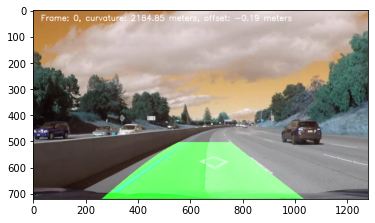

In [62]:
proc = Processor()
proc_image = cv2.imread('project/frame0596.jpeg')
# proc_image = cv2.imread('project/frame0703.jpeg')
proc_image = cv2.imread('challenge/frame0195.jpeg')
plt.imshow(proc.process_image(proc_image))

In [371]:
# clip1.write_images_sequence('challenge/frame%04d.jpeg')

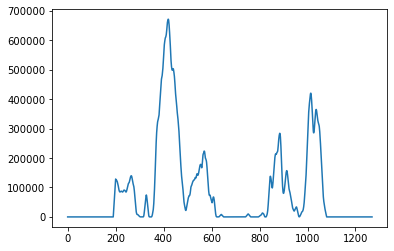

In [20]:
plt.plot(hist(tresholded_hoffed))

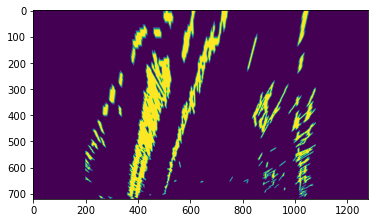

In [21]:
plt.imshow (tresholded_hoffed)

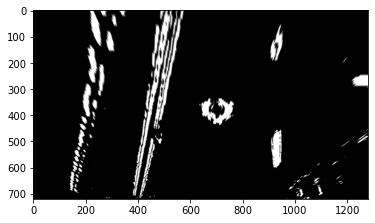

In [52]:
tresholded_img = get_tresholded_img(test_img)
tresholded_img = cv2.warpPerspective(tresholded_img,M,None)
plt.imshow(tresholded_img, cmap='gray')

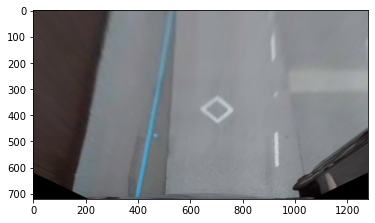

In [15]:
plt.imshow(cv2.warpPerspective(test_img,M,None))